<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S10/S10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import cv2

In [2]:
'''import albumentations as A
import albumentations.pytorch.transforms as AT'''

'import albumentations as A\nimport albumentations.pytorch.transforms as AT'

In [3]:
'''!git clone https://github.com/albumentations-team/albumentations.git
print("GIT Clone for Cutout Done ")
from albumentations.augmentations import transforms as t
ct = t.Cutout(num_holes=8, max_h_size=8, max_w_size=8,  always_apply=False, p=0.5)'''

'!git clone https://github.com/albumentations-team/albumentations.git\nprint("GIT Clone for Cutout Done ")\nfrom albumentations.augmentations import transforms as t\nct = t.Cutout(num_holes=8, max_h_size=8, max_w_size=8,  always_apply=False, p=0.5)'

In [4]:
from google.colab import files
files.upload()

Saving resnetmodel.py to resnetmodel (1).py


{'resnetmodel.py': b'import torch\r\nimport torch.nn as nn\r\nimport torch.nn.functional as F\r\n\r\n\r\nclass BasicBlock(nn.Module):\r\n    expansion = 1\r\n\r\n    def __init__(self, in_planes, planes, stride=1):\r\n        super(BasicBlock, self).__init__()\r\n        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)\r\n        self.bn1 = nn.BatchNorm2d(planes)\r\n        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)\r\n        self.bn2 = nn.BatchNorm2d(planes)\r\n        self.shortcut = nn.Sequential()\r\n        if stride != 1 or in_planes != self.expansion*planes:\r\n            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),\r\n                                          nn.BatchNorm2d(self.expansion*planes)\r\n                                          )\r\n\r\n    def forward(self, x):\r\n        out = F.relu(self.bn1(self.conv1(

In [0]:
from resnetmodel import *

In [6]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

trans = transforms.Compose([ transforms.ToTensor(),
                             transforms.Normalize(mean, std)
                            ]) 
'''train_transform = transforms.Compose( [transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomCrop(32, padding=2),
                                       #transforms.RandomErasing(),
                                       A.Cutout(),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ]
                                      )'''

'''train_transform = A.Compose([ A.PadIfNeeded(min_height=36, min_width=36),
                               A.RandomCrop(height=32, width=32),
                               A.HorizontalFlip(),
                               A.Normalize(mean,std),
                               A.Cutout(num_holes=4),
                               AT.ToTensor()
                              ]
                            )'''

'train_transform = A.Compose([ A.PadIfNeeded(min_height=36, min_width=36),\n                               A.RandomCrop(height=32, width=32),\n                               A.HorizontalFlip(),\n                               A.Normalize(mean,std),\n                               A.Cutout(num_holes=4),\n                               AT.ToTensor()\n                              ]\n                            )'

In [7]:
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, VerticalFlip, Resize,Rotate , Cutout
from albumentations.pytorch import ToTensor
import numpy as np

class train_transforms():

    def __init__(self):
        self.albTrainTransforms = Compose([  # Resize(256, 256),
            Rotate((-10.0, 10.0)),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Cutout(num_holes = 8, max_h_size = 8, max_w_size = 8),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensor()
        ])# this is train transforms

    print("REQUIRED LIBRARIES LOADED...")

    def __call__(self, img):
        img = np.array(img)
        img = self.albTrainTransforms(image=img)['image']
        return img

REQUIRED LIBRARIES LOADED...


In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=train_transforms() )
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=30,
                                          shuffle=True,
                                          num_workers=4, 
                                          pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=trans)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=30,
                                         shuffle=False, 
                                         num_workers=4, 
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


truck plane plane  frog


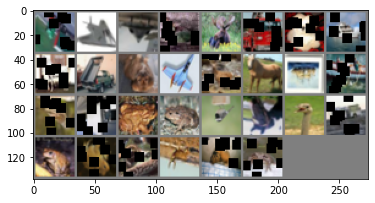

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = next(iter(trainloader))
images, labels = dataiter

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=0.001)

schedular= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, 
                             threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

cuda


In [15]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 900 == 899:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 899))
            running_loss = 0.0

print('Finished Training')

[1,   900] loss: 2.081
[2,   900] loss: 1.683
[3,   900] loss: 1.518
[4,   900] loss: 1.431
[5,   900] loss: 1.399
[6,   900] loss: 1.367
[7,   900] loss: 1.344
[8,   900] loss: 1.329
[9,   900] loss: 1.312
[10,   900] loss: 1.314
[11,   900] loss: 1.310
[12,   900] loss: 1.301
[13,   900] loss: 1.292
[14,   900] loss: 1.296
[15,   900] loss: 1.295
[16,   900] loss: 1.301
[17,   900] loss: 1.299
[18,   900] loss: 1.298
[19,   900] loss: 1.284
[20,   900] loss: 1.296


KeyboardInterrupt: ignored

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


In [0]:
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.autonotebook import tqdm
class LRFinder(object):
    """Learning rate range test.

    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.

    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as model.

    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)

    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai

    """

    def __init__(self, model, optimizer, criterion, device=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_state = model.state_dict()
        self.model_device = next(self.model.parameters()).device
        self.optimizer_state = optimizer.state_dict()

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""
        self.model.load_state_dict(self.model_state)
        self.model.to(self.model_device)
        self.optimizer.load_state_dict(self.optimizer_state)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
    ):
        """Performs the learning rate range test.

        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if None the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.

        """
        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iterator = iter(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Get a new set of inputs and labels
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(train_loader)
                inputs, labels = next(iterator)

            # Train on batch and retrieve loss
            loss = self._train_batch(inputs, labels)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")
    def _train_batch(self, inputs, labels):
        # Set model to training mode
#         self.model.train()

        # Move data to the correct device
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)

        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)

        # Backward pass
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move data to the correct device
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass and loss computation
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True):
        """Plots the learning rate range test.

        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.

        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Plot loss as a function of the learning rate
        plt.plot(lrs, losses)
        if log_lr:
         plt.xscale("log")
         plt.xlabel("Learning rate")
         plt.ylabel("Loss")
         plt.show()

class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.

    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.

    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float, optional): the initial learning rate which is the lower
            boundary of the test. Default: 10.
        num_iter (int, optional): the number of iterations over which the test
            occurs. Default: 100.
        last_epoch (int): the index of last epoch. Default: -1.

    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



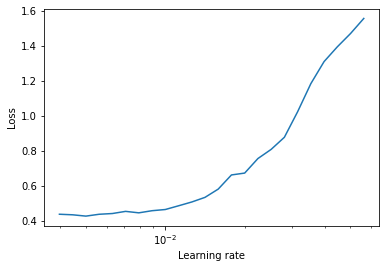

In [14]:
lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader,end_lr=100,num_iter=100,step_mode="exp")
lr_finder.plot()